## Part 2: Similarity Network Fusion

In [1]:
import pickle
import os
import sys
import matplotlib.pyplot as plt
import urllib
import urllib as ul
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import json
import networkx as nx
import ast
from prettytable import PrettyTable
import gseapy as gp
from palettable import wesanderson

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings('ignore')

In [2]:
print(os.getcwd())
current_dir = os.path.dirname(os.path.abspath('__file__'))
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(parent_dir)
print(parent_dir)

/Users/chaeeunlee/Documents/VSC_workspaces/ISMB_Test/Section2
/Users/chaeeunlee/Documents/VSC_workspaces/ISMB_Test


#### Paths

In [3]:
# Define paths to .gml network files from Section 1
# These paths point to the Gene correlation network, Patient network from (1) TCGA gene expression data and (2) TCGA DNA methylation data.
G_patient_gxp_path = 'section2_data/section2_networks_v2/patient_coexpression_network_knn.gml'
G_patient_dnam_path = 'section2_data/section2_networks_v2/patient_meth_network_knn.gml'

# Load the GML graphs into NetworkX graph objects
# nx.read_gml() function reads a graph from a GML file
G_patient_gxp = nx.read_gml(G_patient_gxp_path)  # Patient gene expression network
G_patient_dnam = nx.read_gml(G_patient_dnam_path)  # Patient methylation network

# Get all nodes in each graph
# The nodes represent genes or patients depending on the network
G_patient_gxp_nodes_list = list(G_patient_gxp.nodes())  # Patient nodes
G_patient_dnam_nodes_list = list(G_patient_dnam.nodes())  # Patient nodes

# Define paths to the raw TCGA datasets
tcga_dnam_path = 'section2_data/ISMB_TCGA_DNAm.pkl'  # TCGA DNA methylation data
tcga_gxp_path = 'section2_data/ISMB_TCGA_GE.pkl'  # TCGA Gene expression data

# Load the gene expression dataset
# pd.read_pickle() function loads a pickled pandas DataFrame or Series
tcga_gxp = pd.read_pickle(tcga_gxp_path)
# Extract metadata from the gene expression dataset
# Metadata might include information such as patient IDs, sample conditions, etc.
tcga_gxp_meta = tcga_gxp['datMeta']

# For this example, we'll use a CSV file that includes gene symbols
# pd.read_csv() function loads a CSV file into a pandas DataFrame
tcga_gxp_df = pd.read_csv('section2_data/tcga_ge_df_symbols_t.csv')  # Dataset with gene symbols
# Set 'GENES' column as the index for easy access to gene-specific data
tcga_gxp_df.set_index('GENES', inplace=True)



In [4]:
tcga_gxp_meta_dict = tcga_gxp_meta.to_dict()
print(tcga_gxp_meta_dict.keys())

dict_keys(['patient', 'race', 'gender', 'sample_type', 'cigarettes_per_day', 'Smoked', 'sizeFactor', 'replaceable'])


#### Import custom functions

In [5]:
from functions import get_k_neighbours, draw_network_with_node_attrs # get_edge_attributes

### 2. Patient Network Analysis

In Part 1, we worked with gene expression networks, where each node represented a gene. In Part 2, our focus shifts to patient networks. In Patient Similarity Networks (PSNs), each node represents an individual patient and the edges encode similarities between patients, based on various modalities of data such as gene expression profiles and DNA methylation patterns.

#### 2.1 Clustering on Individual Patient Networks

We can apply clustering on PSNs and identify patterns in relation to a phenotypic attribute (e.g., smoking status)

In [6]:
from itertools import chain

def get_edge_attributes(G):
    """
    Extracts edge attributes from a graph.

    Args:
        G (networkx.Graph): The graph from which to extract edge attributes.

    Returns:
        list: A list of edge attributes.

    Raises:
        ValueError: If the graph G is empty or not defined.
    """
    if not G:
        raise ValueError("The graph is empty or not defined.")

    # Extract edge attributes
    edge_attributes = list(set(chain.from_iterable(d.keys() for *_, d in G.edges(data=True)))
    )
    return edge_attributes

G_patient_gxp_weight = get_edge_attributes(G_patient_gxp)[0]
G_patient_dnam_weight = get_edge_attributes(G_patient_dnam)[0]

print(f"G_patient_gxp_weight: {G_patient_gxp_weight}, G_patient_dnam_weight: {G_patient_dnam_weight}")

G_patient_gxp_weight: weight, G_patient_dnam_weight: weight


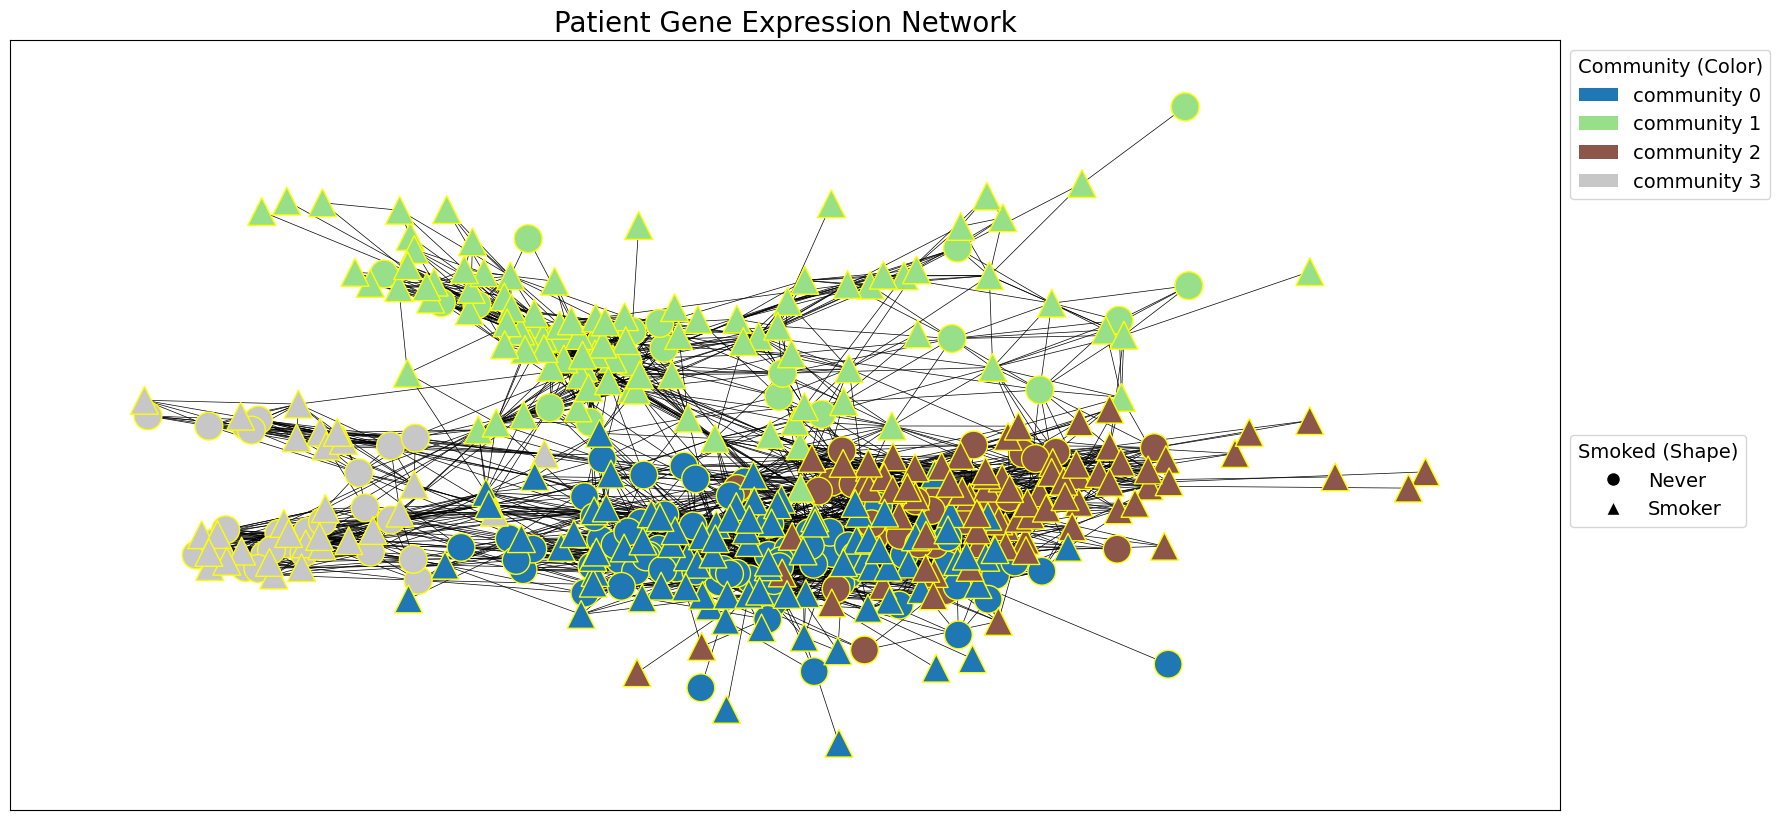

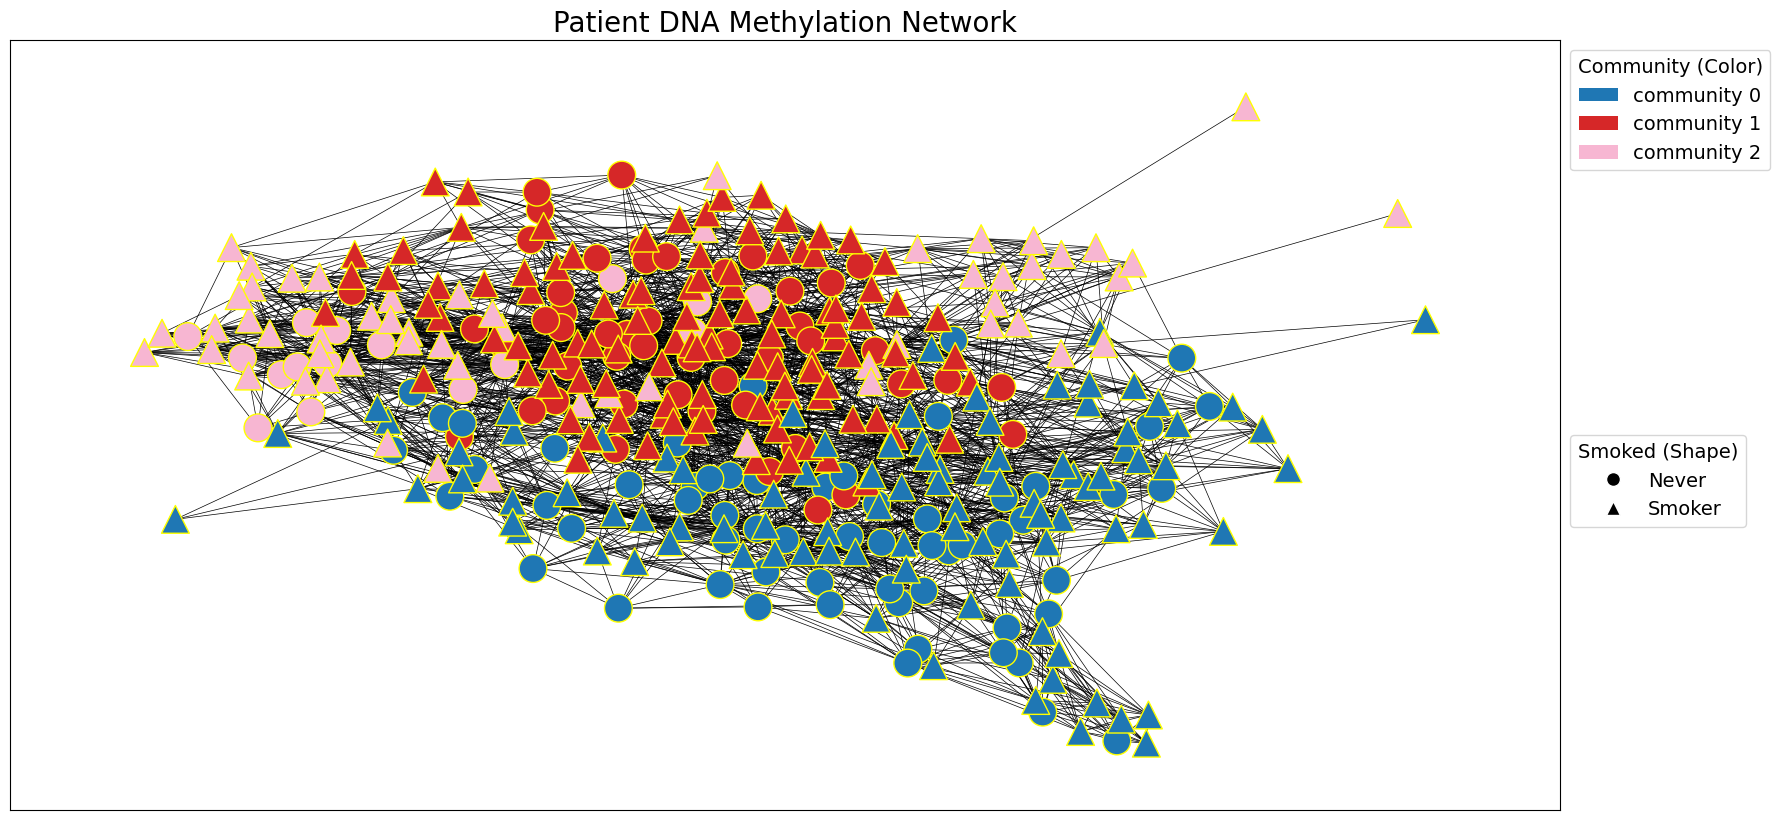

In [7]:
# Use the greedy modularity maximization method to detect communities in the patient network.
patient_gxp_communities = nx.algorithms.community.modularity_max.greedy_modularity_communities(G_patient_gxp) # , weight=G_patient_gxp_weight)
patient_dnam_communities = nx.algorithms.community.modularity_max.greedy_modularity_communities(G_patient_dnam) #, weight=G_patient_dnam_weight)

# Visualize the patient network with identified communities.
draw_network_with_node_attrs(G_patient_gxp, tcga_gxp_meta_dict, title='Patient Gene Expression Network', communities=patient_gxp_communities, color_attr='community', shape_attr='Smoked', layout='spring', with_labels=False)
draw_network_with_node_attrs(G_patient_dnam, tcga_gxp_meta_dict, title='Patient DNA Methylation Network', communities=patient_dnam_communities, color_attr='community', shape_attr='Smoked', layout='spring', with_labels=False)

#### 2.2 Similarity Network Fusion (SNF)


When working with patient data, we often want to combine information from multiple modalities. Here, we use Similarity Network Fusion (SNF) to integrate patient data in the space of samples (e.g., patients) rather than measurements (e.g., gene expression) [(Wang et al.)](https://pubmed.ncbi.nlm.nih.gov/24464287/).

SNF consists of two main steps:

1. Construction of Patient-Similarity Networks (`Section 1`): 

    - For each type of data (e.g., gene expression, DNA methylation), SNF constructs a patient-by-patient similarity matrix. This matrix represents a similarity network where nodes are samples (patients) and weighted edges represent the pairwise similarities between them. 

2. Integration of Networks: 

    - Using a nonlinear combination method based on message-passing theory, SNF iteratively updates each network with information from the others. This process aligns each network more closely to the other with every iteration. The iterative update continues until convergence, resulting in a single integrated similarity network.


We use the Python library [`snfpy`](https://github.com/rmarkello/snfpy) to perform Similarity Network Fusion (SNF) on two patient networks. We start by identifying the overlapping patient nodes between gene expression (`G_patient_gxp`) and DNA methylation (`G_patient_dnam`) networks to ensure the networks represent the same patients. We then create adjacency matrices for these networks and use them as input for SNF. SNF fuses these networks into a single network (`G_snf`) that captures information from both modalities. The resulting SNF adjacency matrix is converted to a NetworkX graph, and edges with weights below a cutoff are removed to enhance community detection. Additionally, we perform a k-nearest neighbors (KNN) procedure on the SNF adjacency matrix to create another network (`G_snf_knn`). This step emphasises local neighborhood structures within the fused network. 

In [8]:
import snf

In [9]:
# Get overlapping patient nodes from the two patient networks
# In patient networks, the nodes represent patients. We want to ensure that there are sufficient number of nodes commonly found in the networks of different modalities before Similarity Network Fusion (SNF), so that they represent different aspects of the same patients.
all_idx = list(set(G_patient_gxp_nodes_list) & set(G_patient_dnam_nodes_list))
print(f"Number of overlapping patient nodes: {len(all_idx)}")

# Create adjacency matrix for G_patient_gxp with overlapping nodes
G_patient_gxp_adj_matrix = nx.to_pandas_adjacency(G_patient_gxp, nodelist=all_idx, weight=G_patient_gxp_weight)

# Create adjacency matrix for G_patient_dnam with overlapping nodes
G_patient_dnam_adj_matrix = nx.to_pandas_adjacency(G_patient_dnam, nodelist=all_idx, weight=G_patient_dnam_weight)

Number of overlapping patient nodes: 381


In [10]:
full_graphs = [] # List of adjacency (similarity) matrices
full_graphs.append(G_patient_gxp_adj_matrix)
full_graphs.append(G_patient_dnam_adj_matrix) 

In [11]:
# Set the number of nearest neighbors and the number of iterations for SNF
k = 12
cutoff_weight = 0.003 # Edges with weights below a cutoff are removed to enhance community detection

# Perform SNF
# 'K' is the number of nearest neighbors used in SNF, 't' is the number of iterations
adj = snf.snf(full_graphs, K=k, t=10)

# Convert the resulting SNF matrix back into a pandas DataFrame for easier manipulation
adj_snf = pd.DataFrame(data=adj, index=all_idx, columns=all_idx)   
# Convert the DataFrame to a NumPy array
adj_snf_data = adj_snf.values
np.fill_diagonal(adj_snf_data, 0)

# Convert the adjacency matrix to a NetworkX graph
G_snf = nx.from_numpy_array(adj_snf_data)
# Set the node labels using the DataFrame index
G_snf = nx.relabel_nodes(G_snf, dict(enumerate(adj_snf.index)))

# Remove edges with weight under cutoff value
edges_to_remove = [(u, v) for u, v, d in G_snf.edges(data=True) if d['weight'] < cutoff_weight]
G_snf.remove_edges_from(edges_to_remove)


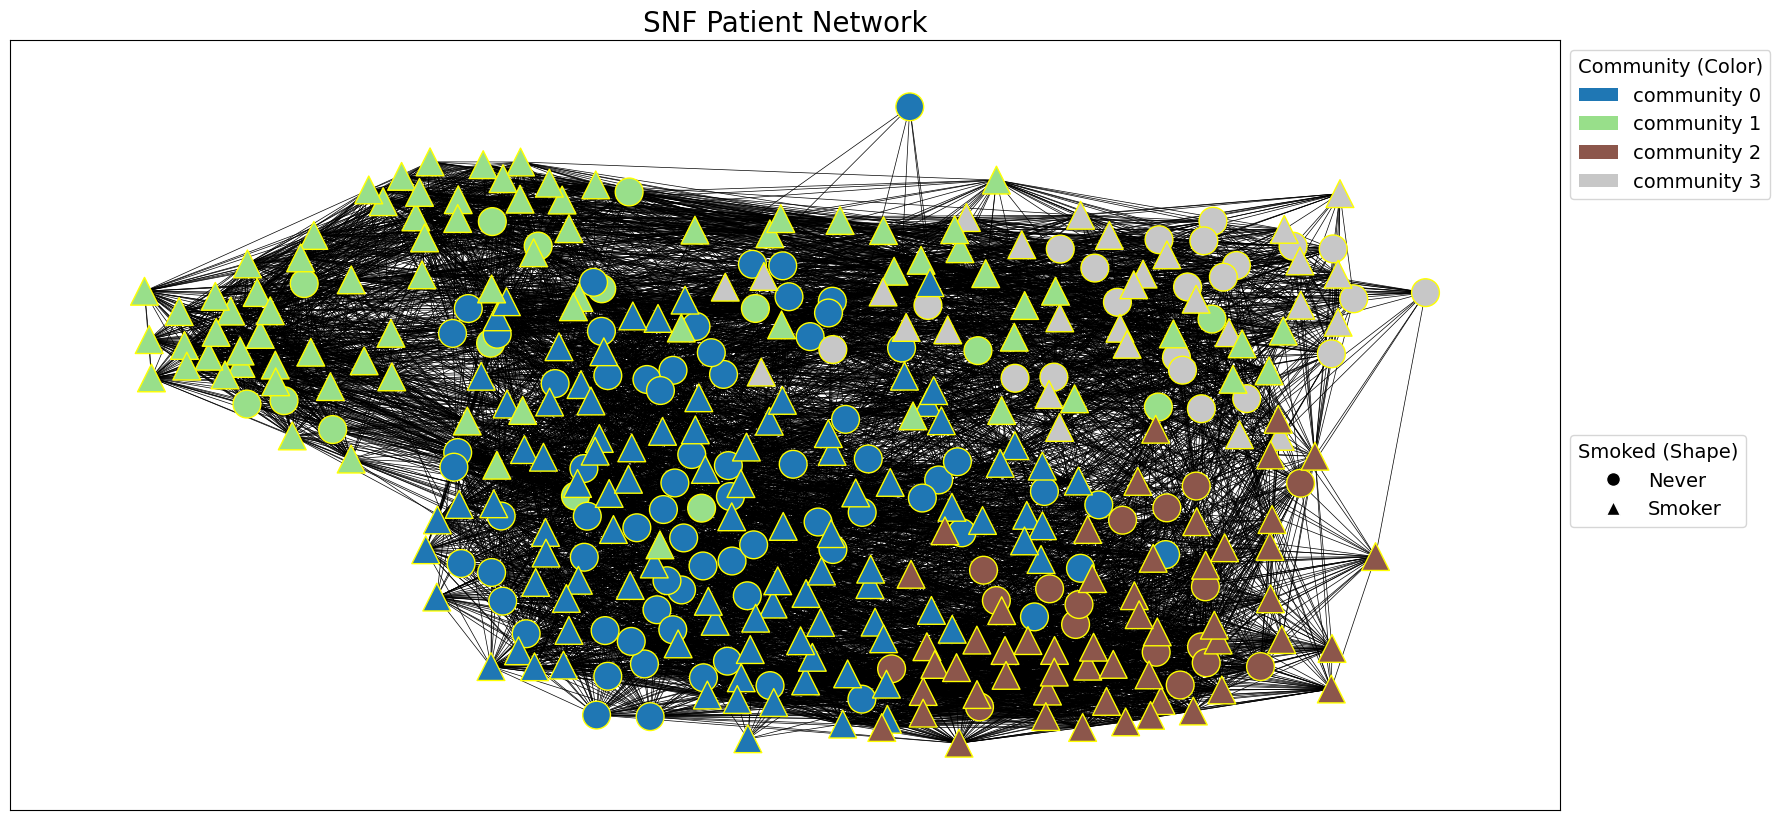

In [12]:
# Cluster G_snf using greedy modularity communities algorithm
snf_communities = nx.algorithms.community.modularity_max.greedy_modularity_communities(G_snf, weight='weight')
draw_network_with_node_attrs(G_snf, node_attributes=tcga_gxp_meta_dict, title='SNF Patient Network', communities=snf_communities, color_attr='community', shape_attr='Smoked', layout='spring', with_labels=False)

In [14]:
# Compute the k-nearest neighbors for the nodes in the network
k_neighbors = get_k_neighbours(adj_snf, k)
print(f"k_neighbors: {k_neighbors}")

# Create a new NetworkX graph
G_snf_knn = nx.Graph()
G_snf_knn.add_nodes_from(adj_snf.index)

# Add edges between each node and its k-nearest neighbors
for node, neighbors in k_neighbors.items():
    for neighbor in neighbors:
        G_snf_knn.add_edge(node, neighbor)

k_neighbors: {'TCGA-78-7153': ['TCGA-86-7713', 'TCGA-62-A46P', 'TCGA-86-8359', 'TCGA-78-7161', 'TCGA-50-5051', 'TCGA-55-8615', 'TCGA-91-7771', 'TCGA-MP-A4TD', 'TCGA-53-7813', 'TCGA-50-7109', 'TCGA-05-4390', 'TCGA-69-7973'], 'TCGA-49-4488': ['TCGA-69-A59K', 'TCGA-62-A46R', 'TCGA-44-8117', 'TCGA-64-5778', 'TCGA-50-5066', 'TCGA-49-AARO', 'TCGA-55-7907', 'TCGA-75-6207', 'TCGA-95-7039', 'TCGA-75-5125', 'TCGA-L9-A8F4', 'TCGA-99-8025'], 'TCGA-97-7937': ['TCGA-71-6725', 'TCGA-78-7535', 'TCGA-55-8514', 'TCGA-86-8279', 'TCGA-95-7039', 'TCGA-05-4405', 'TCGA-55-8616', 'TCGA-71-8520', 'TCGA-55-8506', 'TCGA-44-8117', 'TCGA-05-5423', 'TCGA-55-8096'], 'TCGA-53-7626': ['TCGA-55-7724', 'TCGA-55-7914', 'TCGA-97-A4M7', 'TCGA-99-7458', 'TCGA-93-7348', 'TCGA-55-A48X', 'TCGA-86-8056', 'TCGA-50-8457', 'TCGA-55-7281', 'TCGA-NJ-A4YG', 'TCGA-91-8497', 'TCGA-97-8172'], 'TCGA-75-5147': ['TCGA-55-A491', 'TCGA-50-5936', 'TCGA-86-7953', 'TCGA-49-AAQV', 'TCGA-86-8055', 'TCGA-64-1679', 'TCGA-73-7499', 'TCGA-55-8096', '

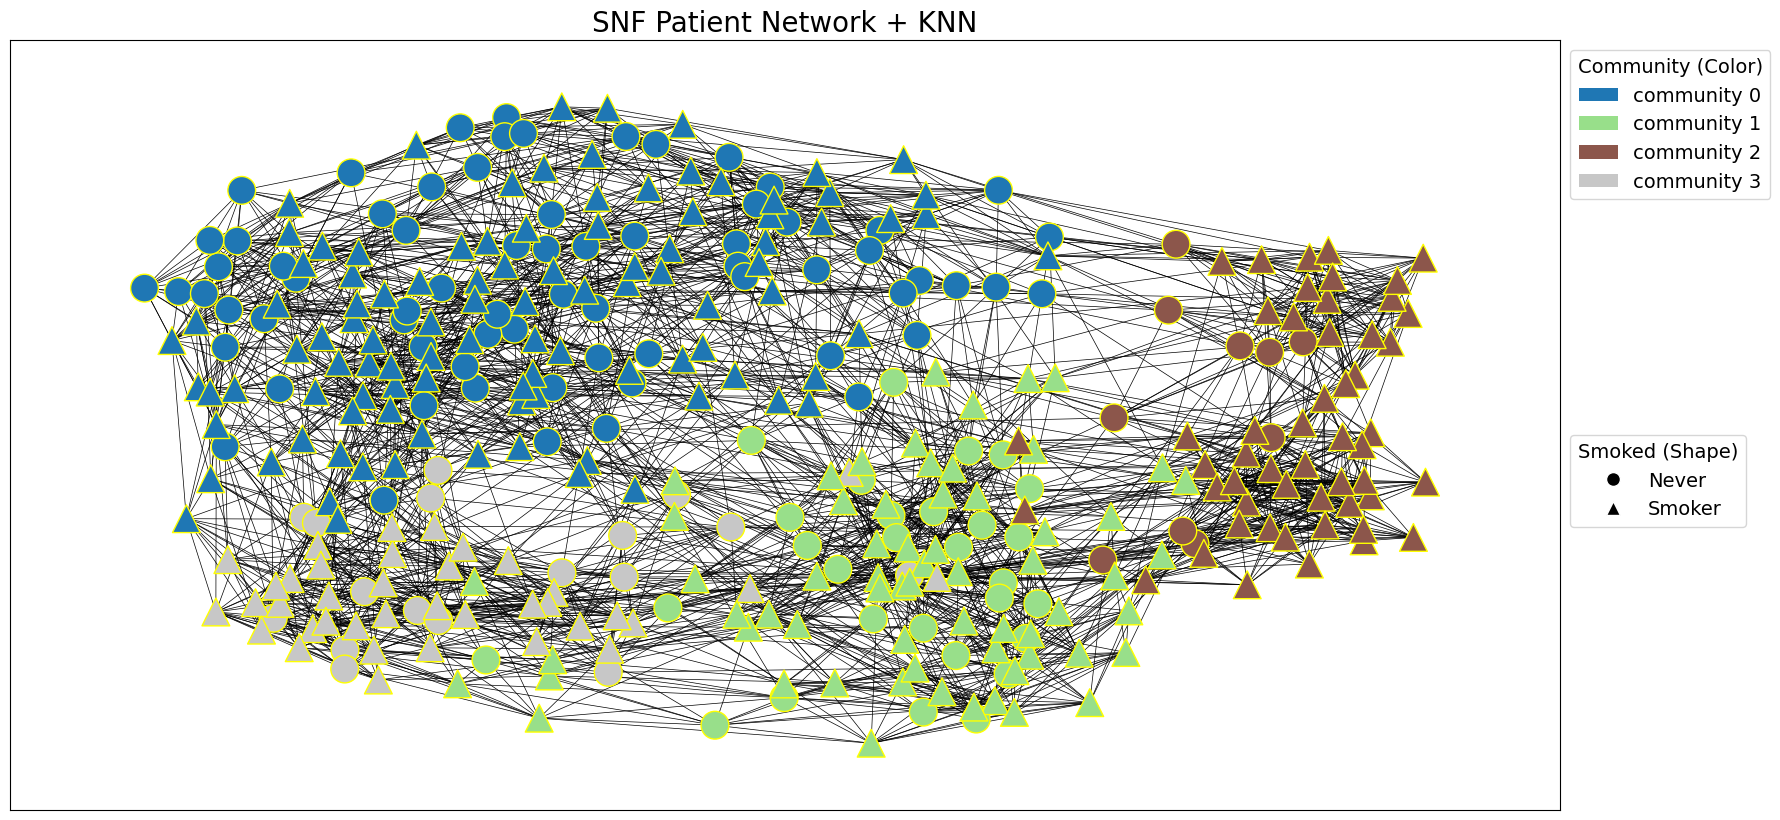

In [15]:
# Cluster G_snf_knn using greedy modularity communities algorithm
snf_knn_communities = nx.algorithms.community.modularity_max.greedy_modularity_communities(G_snf_knn) # , weight='weight')
draw_network_with_node_attrs(G_snf_knn, node_attributes=tcga_gxp_meta_dict, title='SNF Patient Network + KNN', communities=snf_knn_communities, color_attr='community', shape_attr='Smoked', layout='spring', with_labels=False)